## SIH PS 25176

To develop AI/ML based models to predict time-varying patterns of the error build up between uploaded and modelled values of both satellite clock and ephemeris parameters of navigation satellites

### Background

The accuracy of Global Navigation Satellite Systems (GNSS) is fundamentally limited by errors in satellite clock biases and ephemeris (satellite orbit) predictions. These errors, if not accurately modeled and predicted, can lead to significant deviations in positioning and timing solutions. This challenge tasks participants with developing and applying generative Artificial Intelligence (AI) and Machine Learning (ML) methods to model and predict the differences between uploaded (broadcast) and ICD based modelled values. The goal is to produce highly accurate error predictions for future time intervals, enhancing the reliability and precision of GNSS applications.

### Detailed Description

Participants will be provided with a seven-day dataset containing recorded clock and ephemeris errors between uploaded and modeled values from GNSS satellites in both GEO/GSO and MEO. The models must be capable of predicting these errors at 15-minute intervals for an eighth day that is not included in the training data. Evaluation will focus on the accuracy of these predictions over various validity periods: 15 minutes, 30 minutes, 1 hour, 2 hours, and up to 24 hours into the future from the last known data point. Competitors are encouraged to explore a wide range of generative AI/ML techniques, including but not limited to:

- Recurrent Neural Networks (RNNs), such as Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRUs), for time-series forecasting.
- Generative Adversarial Networks (GANs) for synthesizing realistic error patterns.
- Transformers for capturing long-range dependencies in the data.
- Gaussian Processes for probabilistic modeling of errors.

### Expected Solution

- Successful models will demonstrate robust performance across all prediction horizons and provide insights into the underlying dynamics of GNSS errors.
- The error distribution from the proposed model will be evaluated in terms of closeness to the normal distribution. Closer the error distribution to the normal distribution, better will be the performance.


In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

In [2]:
def df_from_csv(file_path):
    """
    Reads a time-series CSV, and returns it as dataframe
    """
    df = pd.read_csv(file_path, parse_dates=['utc_time'])
    df = df.sort_values('utc_time').reset_index(drop=True)
    df = df.drop_duplicates(subset='utc_time')

    time_sec = df['utc_time'].astype(np.int64) / 1e9
    return df

def interpolate_dataset(file_path, sat_type):
    """
    Reads a time-series CSV, interpolates it to a 15-minute frequency using a 
    cubic spline, adds noise to new points, and restores original data points.
    """
    # 1. Load and prepare the data
    df = pd.read_csv(file_path, parse_dates=['utc_time'])
    df = df.sort_values('utc_time').reset_index(drop=True)
    df = df.drop_duplicates(subset='utc_time')

    # 2. Convert timestamps to a numeric format for interpolation
    time_sec = df['utc_time'].astype(np.int64) / 1e9
    
    # 3. Create the new, complete 15-minute time range
    full_time = pd.date_range(start=df['utc_time'].min(), end=df['utc_time'].max(), freq='15min')
    full_time_sec = full_time.astype(np.int64) / 1e9
    
    # 4. Initialize the output DataFrame
    interpolated = pd.DataFrame({'utc_time': full_time})
    error_cols = [col for col in df.columns if col != 'utc_time']
    
    # 5. Interpolate each data column and add noise to new points
    for col in error_cols:
        cs = CubicSpline(time_sec, df[col])
        interpolated[col] = cs(full_time_sec)
        
        mask_new_points = ~full_time.isin(df['utc_time'])
        if mask_new_points.any(): # Only add noise if there are new points
            residual_std = df[col].diff().std()
            if pd.notna(residual_std) and residual_std > 0:
                noise = np.random.normal(0, residual_std * 0.5, len(full_time))
                interpolated.loc[mask_new_points, col] += noise[mask_new_points]
        
    # 6. Restore original values efficiently using .update()
    df_indexed = df.set_index('utc_time')
    interpolated.set_index('utc_time', inplace=True)
    interpolated.update(df_indexed)
    interpolated.reset_index(inplace=True)
    
    # 7. Add satellite type and return the final DataFrame
    interpolated['sat_type'] = sat_type
    return interpolated

In [3]:
meo_exp = interpolate_dataset("DATA_MEO_Train.csv", "MEO")
geo_exp = interpolate_dataset("DATA_GEO_Train.csv", "GEO")
meo2_exp = interpolate_dataset("DATA_MEO_Train2.csv", "MEO")

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
def plot_gnss_errors(df, title="GNSS Error Analysis"):
    """
    Generates a comprehensive 2x2 plot for GNSS error analysis from a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with columns 'utc_time', 'x_error (m)',
                           'y_error (m)', 'z_error (m)', and 'satclockerror (m)'.
        title (str): The main title for the entire plot figure.
    """
    # Ensure utc_time is in datetime format for proper plotting
    df['utc_time'] = pd.to_datetime(df['utc_time'])

    # --- Setup the 2x2 Figure ---
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(title, fontsize=20, fontweight='bold')
    plt.style.use('seaborn-v0_8-whitegrid')

    # 1. Time Series Plot (Top-Left)
    ax[0, 0].plot(df['utc_time'], df['x_error (m)'], label='X Error', alpha=0.8)
    ax[0, 0].plot(df['utc_time'], df['y_error (m)'], label='Y Error', alpha=0.8)
    ax[0, 0].plot(df['utc_time'], df['z_error (m)'], label='Z Error', alpha=0.8)
    ax[0, 0].legend()
    ax[0, 0].set_title('Position Errors over Time', fontsize=14)
    ax[0, 0].set_xlabel('Time', fontsize=12)
    ax[0, 0].set_ylabel('Error (m)', fontsize=12)
    ax[0, 0].tick_params(axis='x', rotation=30)

    # 2. Horizontal Error Scatter Plot (Top-Right)
    ax[0, 1].scatter(df['x_error (m)'], df['y_error (m)'], alpha=0.6, s=15)
    ax[0, 1].set_title('Horizontal Error (X vs Y)', fontsize=14)
    ax[0, 1].set_xlabel('X Error (m)', fontsize=12)
    ax[0, 1].set_ylabel('Y Error (m)', fontsize=12)
    ax[0, 1].axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax[0, 1].axvline(0, color='black', linewidth=0.5, linestyle='--')
    ax[0, 1].set_aspect('equal', adjustable='box')

    # Calculate and plot 2D RMS (DRMS) circle
    drms = np.sqrt(np.mean(df['x_error (m)']**2 + df['y_error (m)']**2))
    circle = patches.Circle((0, 0), radius=drms, fill=False, color='red', linestyle='--', label=f'DRMS: {drms:.2f} m')
    ax[0, 1].add_patch(circle)
    ax[0, 1].legend(handles=[circle], loc='upper right')

    # 3. Position Error Histograms (Bottom-Left)
    ax[1, 0].hist(df['x_error (m)'], bins=30, alpha=0.7, label='X Error', density=True)
    ax[1, 0].hist(df['y_error (m)'], bins=30, alpha=0.7, label='Y Error', density=True)
    ax[1, 0].hist(df['z_error (m)'], bins=30, alpha=0.7, label='Z Error', density=True)
    ax[1, 0].set_title('Position Error Distribution', fontsize=14)
    ax[1, 0].set_xlabel('Error (m)', fontsize=12)
    ax[1, 0].set_ylabel('Probability Density', fontsize=12)
    ax[1, 0].legend()

    # 4. Satellite Clock Error Histogram (Bottom-Right)
    ax[1, 1].hist(df['satclockerror (m)'], bins=30, color='purple', alpha=0.8, density=True)
    ax[1, 1].set_title('Satellite Clock Error Distribution', fontsize=14)
    ax[1, 1].set_xlabel('Clock Error (m)', fontsize=12)

    # Final Touches 
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

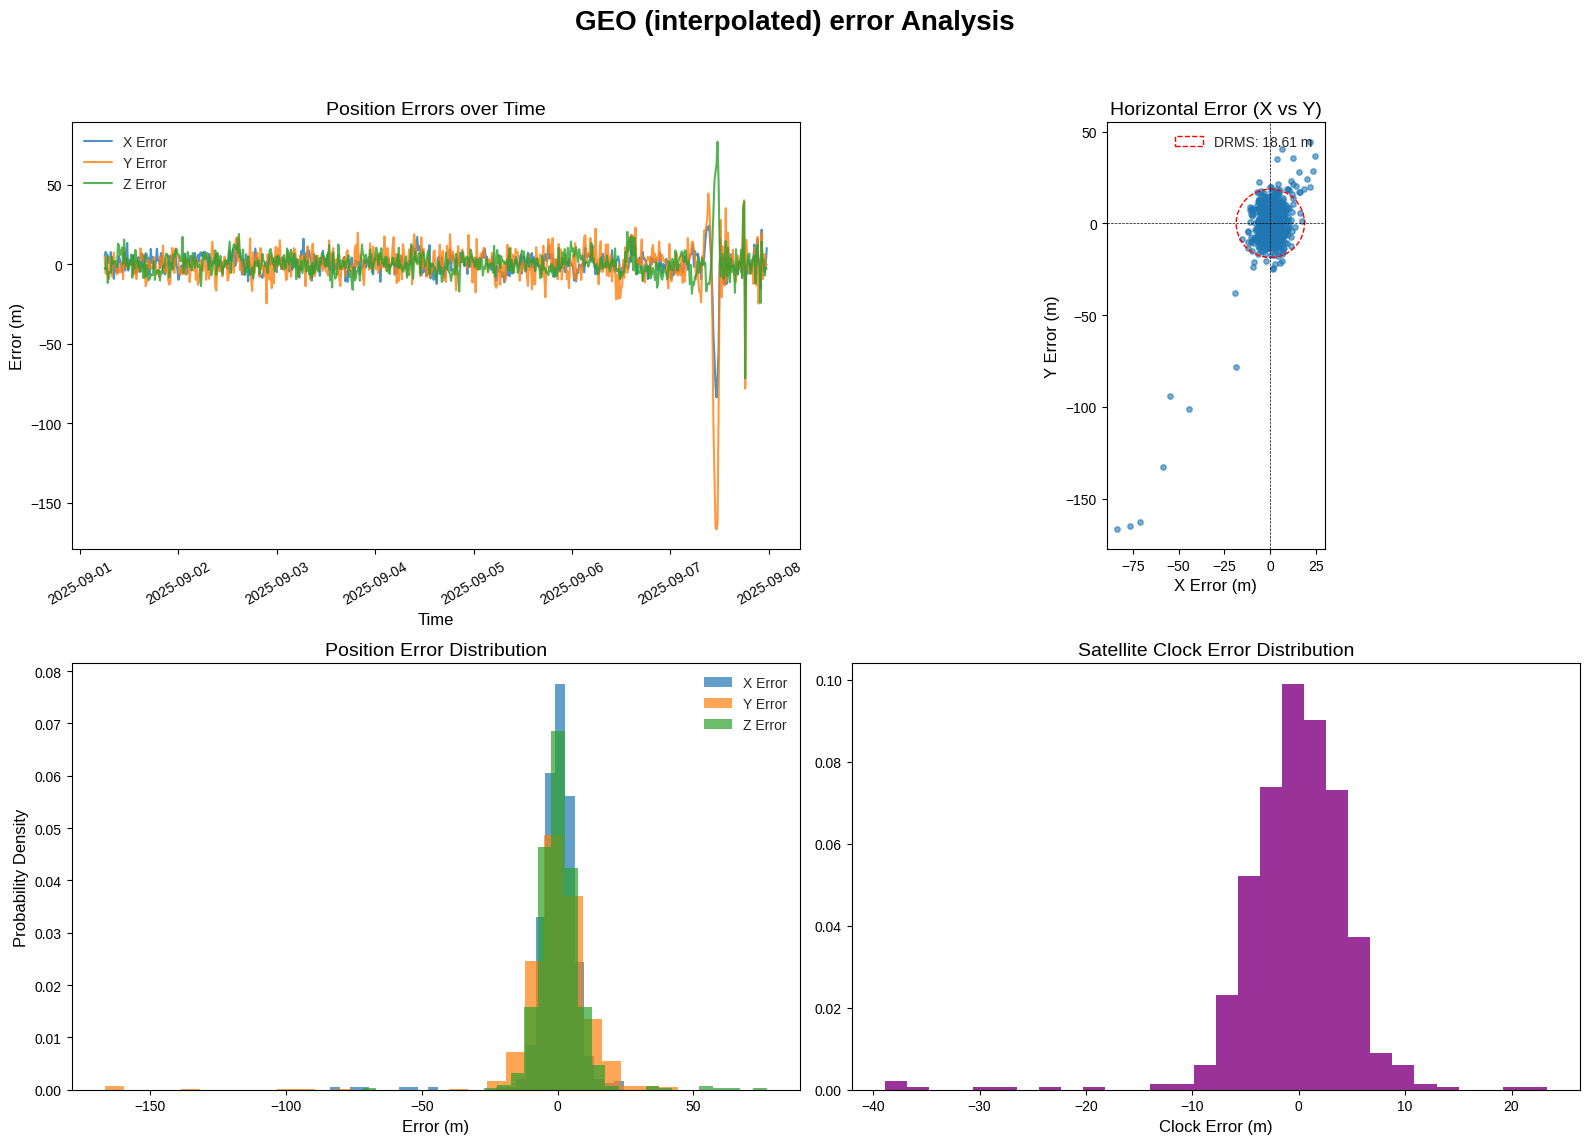

In [6]:
# plot_gnss_errors(df_from_csv("DATA_GEO_Train.csv"), "GEO (raw) error Analysis")
plot_gnss_errors(geo_exp, "GEO (interpolated) error Analysis")

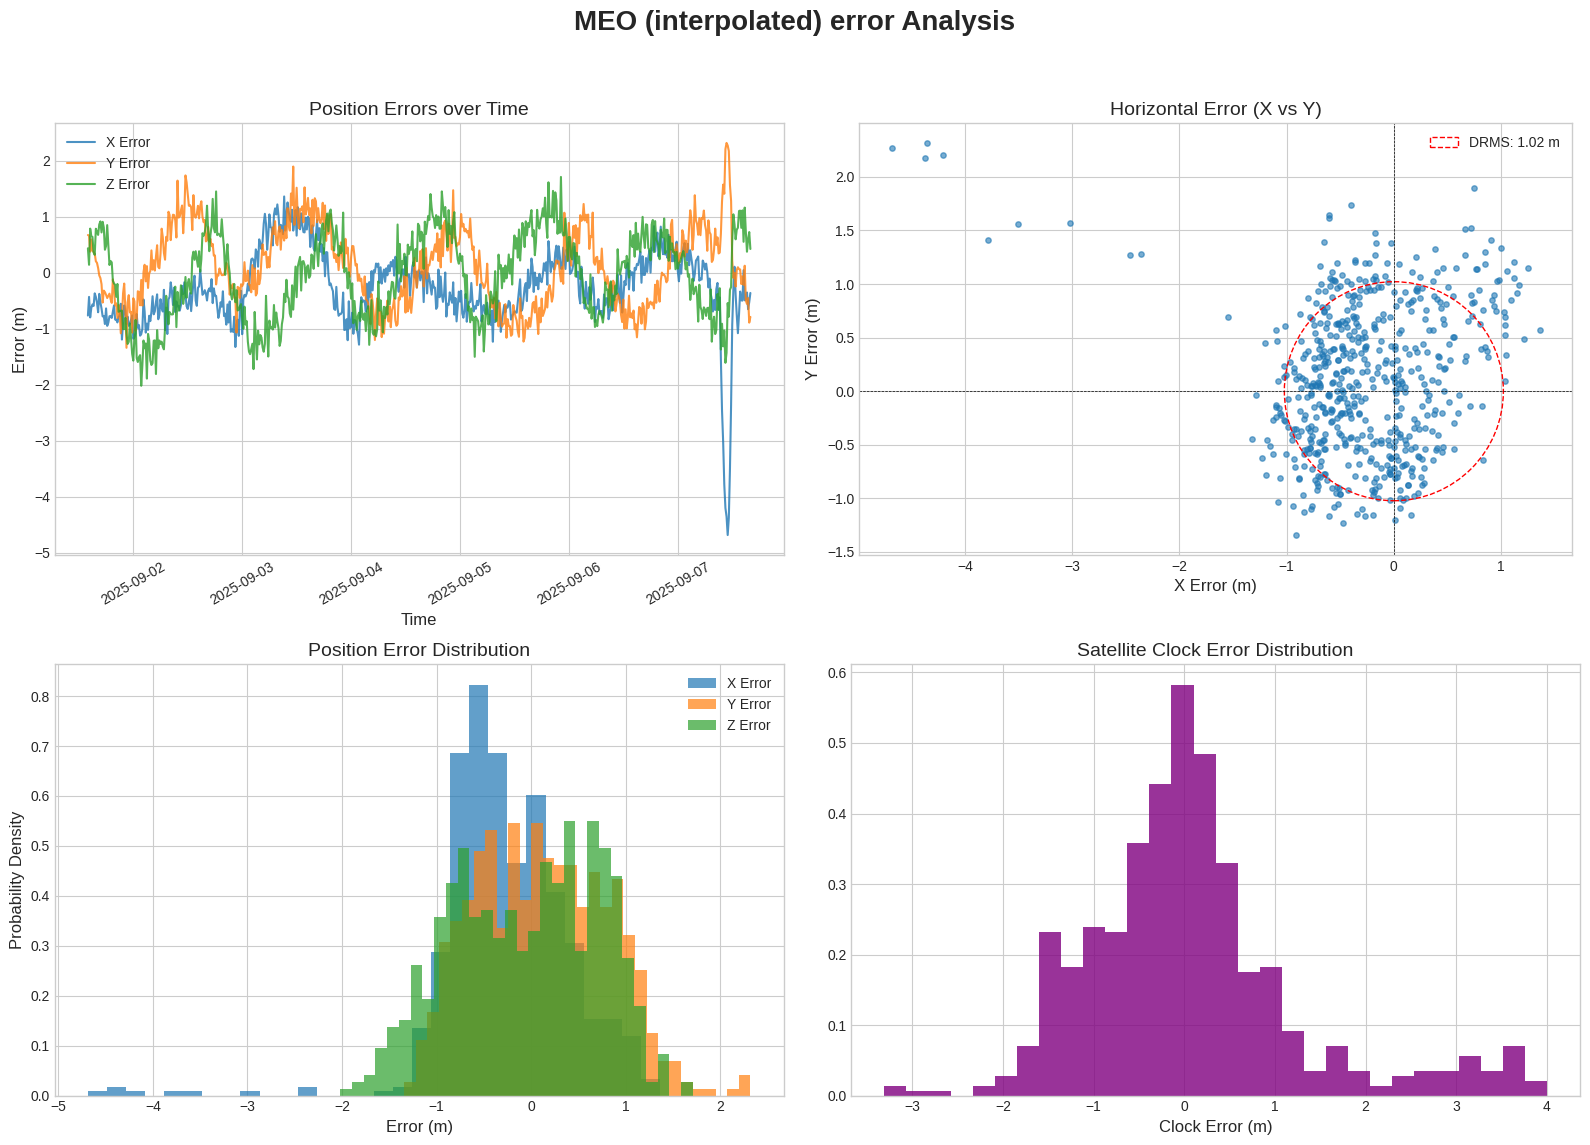

In [7]:
plot_gnss_errors(meo_exp, "MEO (interpolated) error Analysis")

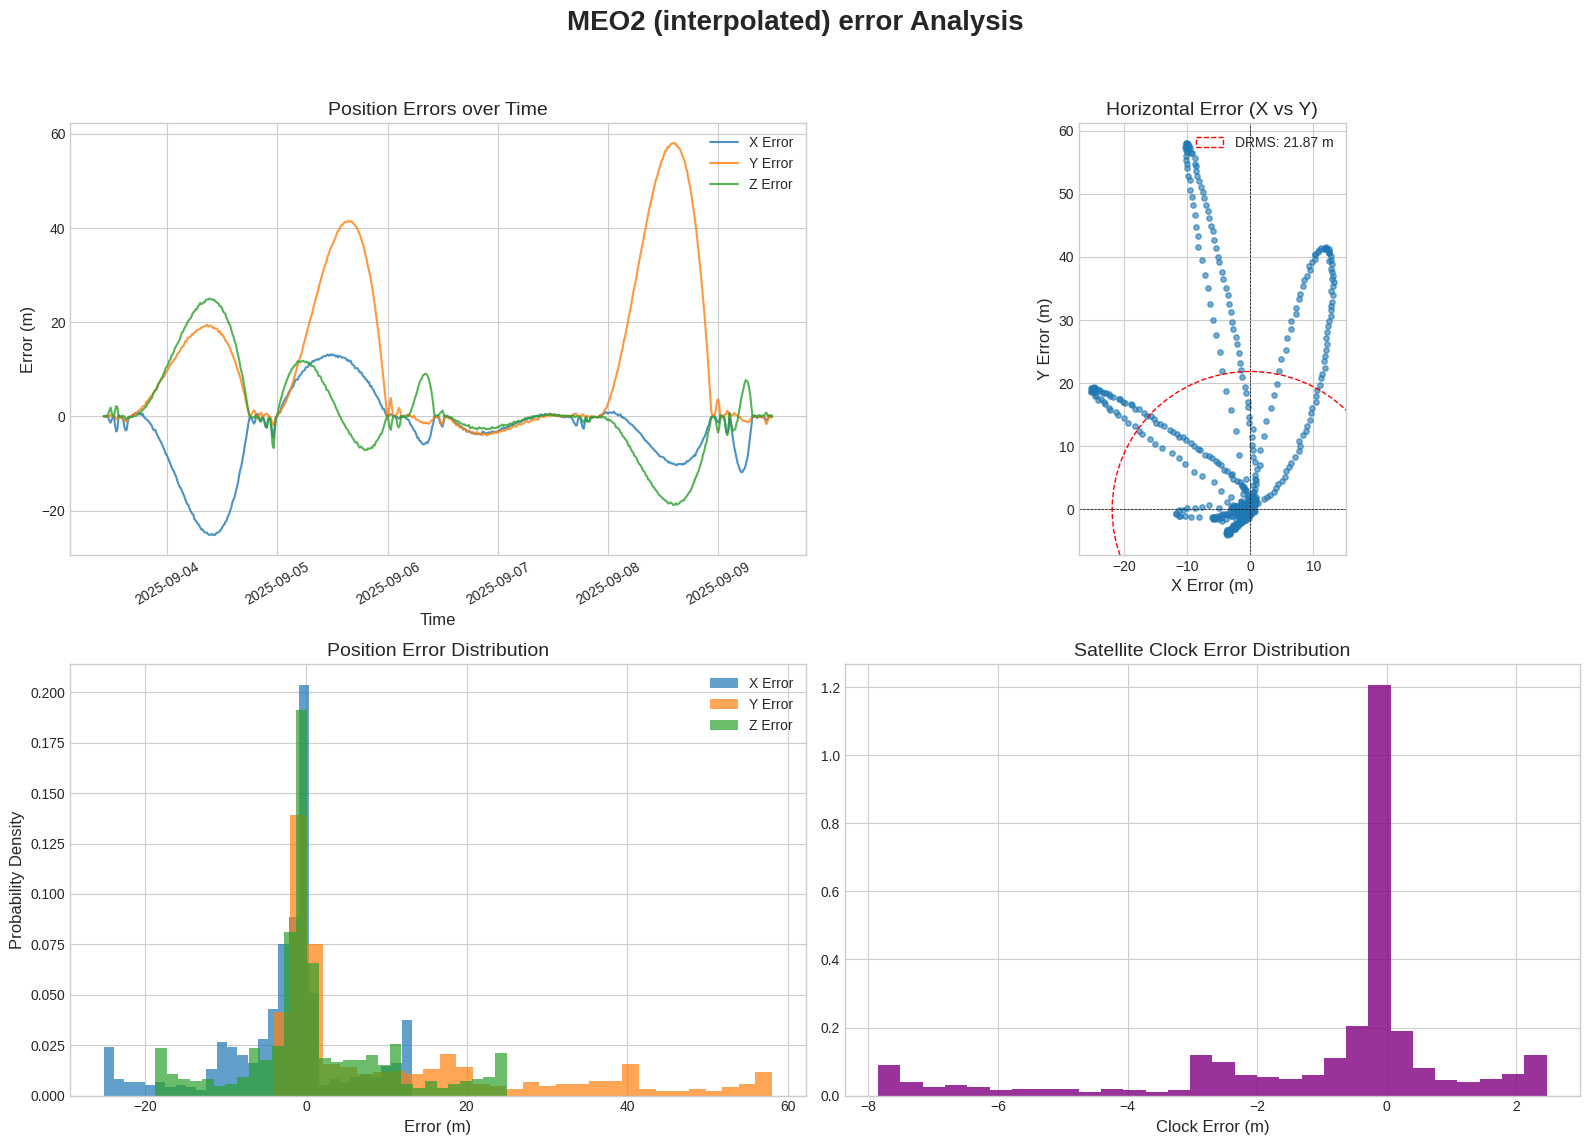

In [8]:
plot_gnss_errors(meo2_exp, "MEO2 (interpolated) error Analysis")